# Assignment 2

    Author: Group F - Gaurav, Xiaowen Sun, Jheel Harnish Kamdar, Ruijia Xiong
    Created at: 02/15/2023

In [ ]:
# Data processing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

# Machine learning and deep learning libraries
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xiong.ru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/xiong.ru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Data Preprocessing


### 1.1 Dataset Structure

In [ ]:
# Assuming the dataset is in CSV format
df = pd.read_csv('News_Category_Dataset_v3.csv', index_col='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209527 entries, 0 to 209526
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   headline                  209521 non-null  object
 1   category                  209527 non-null  object
 2   short_description         189815 non-null  object
 3   authors                   172109 non-null  object
 4   date                      209527 non-null  object
 5   headline_length           209527 non-null  int64 
 6   short_description_length  209527 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 12.8+ MB


In [ ]:
# Count the number of categories
df['category'].nunique()

42

### 1.2 Clean the Dataset

**Merge identical categories**
So that we have 36 categories in total instead of 42

In [ ]:
df['category'] = df['category'].replace('PARENTS', 'PARENTING')
df['category'] = df['category'].replace('STYLE', 'STYLE & BEAUTY')
df['category'] = df['category'].replace('THE WORLDPOST', 'WORLDPOST')

df['category'] = df['category'].replace('ARTS', 'ARTS & CULTURE')
df['category'] = df['category'].replace('CULTURE & ARTS', 'ARTS & CULTURE')
df['category'] = df['category'].replace('HEALTHY LIVING', 'WELLNESS')

In [ ]:
df['category'].nunique()

36

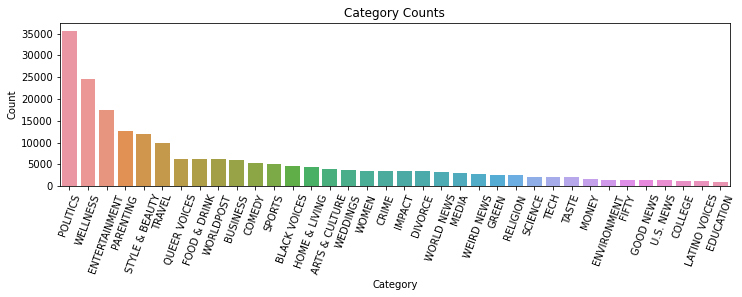

In [ ]:
category_counts = df['category'].value_counts()

# Create a bar plot (histogram) of the category counts using seaborn
plt.figure(figsize=(12, 3))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.xticks(rotation=70)
plt.show()

**Text Cleaning**

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return text

    # Lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # Remove stopwords
    tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in tokens if word not in stop_words])
    return filtered_text


# Applying the preprocess function to each row of the headline and short description
df['cleaned_headline'] = df['headline'].apply(preprocess_text)
df['cleaned_short_description'] = df['short_description'].apply(preprocess_text)
df.head(5)

,headline,category,short_description,authors,date,headline_length,short_description_length,cleaned_headline,cleaned_short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,76,154,million americans roll sleeves omicron targete...,health experts said early predict whether dema...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,89,159,american airlines flyer charged banned life pu...,subdued passengers crew fled back aircraft con...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,69,64,funniest tweets cats dogs week sept,dog understand could eaten
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,56,159,funniest tweets parents week sept,accidentally put grown toothpaste toddler toot...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,77,156,woman called cops black bird watcher loses law...,amy cooper accused investment firm franklin te...


In [ ]:
# Combine cleaned headline and short description for vectorization
df['combined_text'] = df['cleaned_headline'] + ' ' + df['cleaned_short_description']
df['combined_text'] = df['combined_text'].fillna('')

### 1.3 TF-IDF

In [ ]:
# Initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_df=0.85, min_df=80)

# Fit and transform the combined text
feature_vector = vectorizer.fit_transform(df['combined_text'])

In [ ]:
# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Print the number of features (tokens)
print("Number of features:", len(feature_names))

# Print the first 100 features'
print(f"First 100 features: \n{feature_names[0:100]}")

Number of features: 6032
First 100 features: 
['aaron' 'abandon' 'abandoned' 'abc' 'ability' 'able' 'aboard' 'abortion'
 'abortions' 'abroad' 'absence' 'absolute' 'absolutely' 'absurd' 'abuse'
 'abused' 'abusive' 'aca' 'academic' 'academy' 'accept' 'acceptable'
 'acceptance' 'accepted' 'accepting' 'access' 'accessible' 'accessories'
 'accident' 'accidentally' 'accomplish' 'accomplished' 'according'
 'account' 'accountability' 'accountable' 'accounts' 'accurate'
 'accusations' 'accused' 'accuses' 'achieve' 'achieved' 'achievement'
 'achieving' 'acknowledge' 'aclu' 'across' 'act' 'acting' 'action'
 'actions' 'active' 'activism' 'activist' 'activists' 'activities'
 'activity' 'actor' 'actors' 'actress' 'acts' 'actual' 'actually' 'ad'
 'adam' 'adaptation' 'add' 'added' 'addicted' 'addiction' 'adding'
 'addition' 'additional' 'address' 'addressed' 'addresses' 'addressing'
 'adds' 'adele' 'administration' 'admit' 'admits' 'admitted' 'adopt'
 'adopted' 'adoption' 'adorable' 'ads' 'adult' 'adu

In [ ]:
dtm = pd.DataFrame(feature_vector.toarray(), columns=feature_names)
dtm

,aaron,abandon,abandoned,abc,ability,able,aboard,abortion,abortions,abroad,...,youtube,zealand,zen,zero,zika,zoe,zombie,zone,zoo,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Model Implementation and Evaluation

In [ ]:
y = df['category']

In [ ]:
# Encode class values as integers
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [ ]:
# Assuming 'category' is the target variable and 'tfidf_matrix' is your features matrix
X_train, X_temp, y_train, y_temp = train_test_split(feature_vector, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

### 2.1 Logistic Regression

In [ ]:
# Initialize and train the logistic regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict on the test set
lr_pred = lr.predict(X_temp)

# Evaluate performance
lr_report = classification_report(y_temp, lr_pred)
print("Logistic Regression Report:\n", lr_report)

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.57      0.33      0.42       770
           1       0.49      0.27      0.35       889
           2       0.50      0.37      0.42      1216
           3       0.41      0.19      0.26       202
           4       0.57      0.33      0.42      1022
           5       0.50      0.39      0.44       713
           6       0.81      0.64      0.72       664
           7       0.41      0.19      0.26       209
           8       0.56      0.62      0.59      3419
           9       0.61      0.18      0.28       313
          10       0.32      0.03      0.05       263
          11       0.63      0.68      0.65      1270
          12       0.48      0.06      0.11       270
          13       0.36      0.20      0.26       532
          14       0.74      0.64      0.69       879
          15       0.43      0.19      0.26       673
          16       0.73      0.17      0.27       23

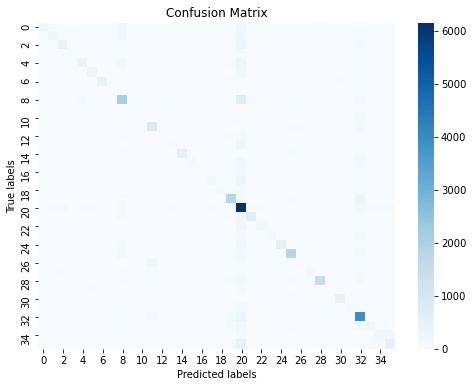

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_temp, lr_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 2.2 Random Forest

In [ ]:
# Compute class weights
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)

# Create and train the random forest classifier with class weights
rf_clf = RandomForestClassifier(class_weight=dict(zip(class_labels, class_weights)))
rf_clf.fit(X_train, y_train)

# Predict on the test set
rf_pred = rf_clf.predict(X_temp)

# Evaluate performance
rf_report = classification_report(y_temp, rf_pred)
print("Random Forest Report:\n", rf_report)

Random Forest Report:
               precision    recall  f1-score   support

           0       0.46      0.29      0.36       770
           1       0.49      0.26      0.34       889
           2       0.45      0.25      0.32      1216
           3       0.30      0.31      0.31       202
           4       0.64      0.31      0.42      1022
           5       0.39      0.31      0.35       713
           6       0.78      0.67      0.72       664
           7       0.30      0.30      0.30       209
           8       0.48      0.44      0.45      3419
           9       0.78      0.15      0.25       313
          10       0.02      0.23      0.03       263
          11       0.54      0.65      0.59      1270
          12       0.33      0.01      0.03       270
          13       0.31      0.17      0.22       532
          14       0.62      0.58      0.60       879
          15       0.52      0.07      0.12       673
          16       0.60      0.23      0.33       238
    

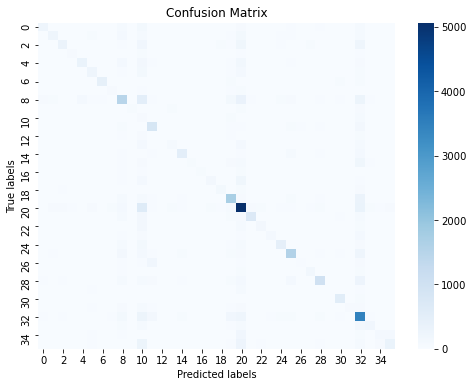

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_temp, rf_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 2.3 XGBoost

In [ ]:
# Initialize and train the XGBoost classifier with encoded labels
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

# Predict on the test set using encoded labels
xgb_pred = xgb_clf.predict(X_temp)

# Evaluate performance
xgb_report = classification_report(y_temp, xgb_pred)
print("XGBoost Report:\n", xgb_report)

XGBoost Report:
               precision    recall  f1-score   support

           0       0.55      0.36      0.43       770
           1       0.48      0.30      0.37       889
           2       0.50      0.34      0.41      1216
           3       0.37      0.28      0.32       202
           4       0.62      0.35      0.45      1022
           5       0.49      0.37      0.42       713
           6       0.80      0.72      0.76       664
           7       0.42      0.32      0.36       209
           8       0.58      0.54      0.56      3419
           9       0.53      0.24      0.33       313
          10       0.27      0.06      0.10       263
          11       0.62      0.63      0.62      1270
          12       0.36      0.07      0.12       270
          13       0.32      0.20      0.25       532
          14       0.72      0.62      0.66       879
          15       0.42      0.16      0.23       673
          16       0.51      0.23      0.31       238
          

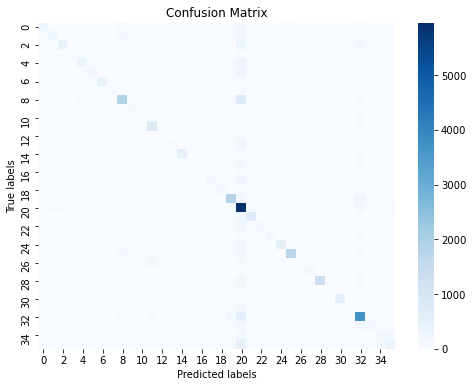

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_temp, xgb_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 2.4 ANN

In [ ]:
# Convert integers to dummy (one-hot encoded) variables
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

In [ ]:
print(f'{X_train.shape}  {X_val.shape}  {X_test.shape}   \n{y_train.shape}   {y_val.shape}   {y_test.shape}   \n{y_train_one_hot.shape}   {y_val_one_hot.shape}   {y_test_one_hot.shape}')

(167621, 6032)  (28077, 6032)  (13829, 6032)   
(167621,)   (28077,)   (13829,)   
(167621, 36)   (28077, 36)   (13829, 36)


In [ ]:
print(f'{type(X_train)}  {type(X_val)}  {type(X_test)}   \n{type(y_train)}   {type(y_val)}   {type(y_test)}  \n{type(y_train_one_hot)}   {type(y_val_one_hot)}   {type(y_test_one_hot)}')

<class 'scipy.sparse._csr.csr_matrix'>  <class 'scipy.sparse._csr.csr_matrix'>  <class 'scipy.sparse._csr.csr_matrix'>   
<class 'numpy.ndarray'>   <class 'numpy.ndarray'>   <class 'numpy.ndarray'>  
<class 'numpy.ndarray'>   <class 'numpy.ndarray'>   <class 'numpy.ndarray'>


In [ ]:
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

Epoch 1/100
2620/2620 [==============================] - 11s 4ms/step - loss: 1.9099 - accuracy: 0.5037 - val_loss: 1.5879 - val_accuracy: 0.5675
Epoch 2/100
2620/2620 [==============================] - 9s 3ms/step - loss: 1.4443 - accuracy: 0.6012 - val_loss: 1.5302 - val_accuracy: 0.5792
Epoch 3/100
2620/2620 [==============================] - 9s 3ms/step - loss: 1.3232 - accuracy: 0.6251 - val_loss: 1.5280 - val_accuracy: 0.5751
Epoch 4/100
2620/2620 [==============================] - 9s 3ms/step - loss: 1.2364 - accuracy: 0.6438 - val_loss: 1.5449 - val_accuracy: 0.5736
Epoch 5/100
2620/2620 [==============================] - 9s 3ms/step - loss: 1.1621 - accuracy: 0.6623 - val_loss: 1.5769 - val_accuracy: 0.5726
Epoch 6/100
2620/2620 [==============================] - 8s 3ms/step - loss: 1.0924 - accuracy: 0.6801 - val_loss: 1.6189 - val_accuracy: 0.5683
Epoch 7/100
2620/2620 [==============================] - 9s 3ms/step - loss: 1.0256 - accuracy: 0.6994 - val_loss: 1.6648 - val_a

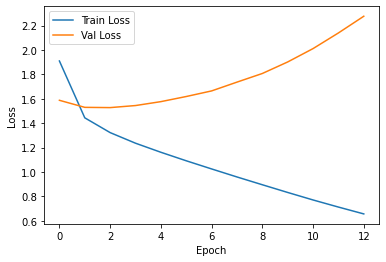

Best Epoch: 3
Validation Loss: 1.5280492305755615


In [ ]:
# Define the ANN model
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(len(df['category'].unique()), activation='softmax'))  # Number of classes

# Compile the model
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Fit the model using the reordered sparse matrices
history = ann_model.fit(X_train, y_train_one_hot, epochs=100, batch_size=64, validation_data=(X_val, y_val_one_hot), callbacks=[early_stop])

# Plot the train loss and the val loss for each epoch
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

best_epoch = np.argmin(history.history['val_loss'])
print("Best Epoch:", best_epoch+1)
print("Validation Loss:", history.history['val_loss'][best_epoch])

In [ ]:
# Evaluate the model on the test data
ann_loss, ann_accuracy = ann_model.evaluate(X_test, y_test_one_hot)
print("ANN Accuracy:", ann_accuracy)

# Predict on test data
y_pred_proba = ann_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert y_test_one_hot back to categorical labels
y_test = np.argmax(y_test_one_hot, axis=1)

# Generate classification report
target_names = ['{}'.format(i) for i in range(len(df['category'].unique()))]
print("ANN Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

433/433 [==============================] - 1s 1ms/step - loss: 1.5039 - accuracy: 0.5859
ANN Accuracy: 0.5859425663948059
433/433 [==============================] - 1s 1ms/step
ANN Report:
              precision    recall  f1-score   support

           0       0.48      0.38      0.42       245
           1       0.52      0.33      0.41       287
           2       0.46      0.40      0.42       387
           3       0.40      0.20      0.27        69
           4       0.61      0.35      0.45       339
           5       0.54      0.41      0.46       250
           6       0.74      0.74      0.74       224
           7       0.57      0.24      0.33        72
           8       0.34      0.74      0.47      1133
           9       0.61      0.22      0.32       105
          10       0.38      0.05      0.09        95
          11       0.62      0.72      0.66       432
          12       0.32      0.07      0.12        85
          13       0.25      0.23      0.24       159


433/433 [==============================] - 1s 1ms/step


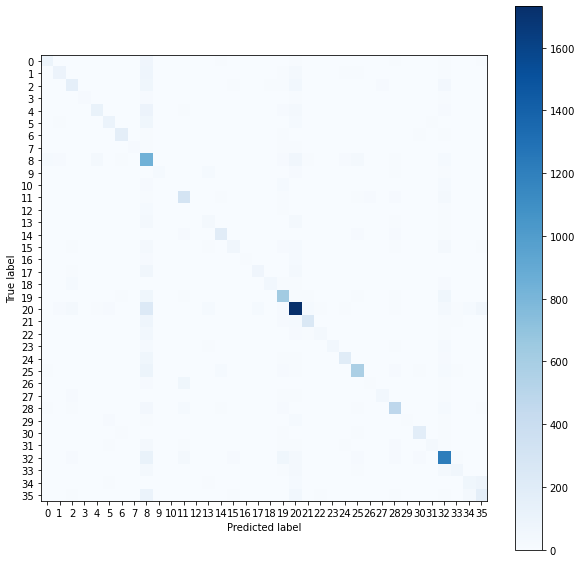

In [ ]:
# 1. Make predictions
y_pred_one_hot = ann_model.predict(X_test)

# 2. Convert predictions from one-hot encoded format to class labels
y_pred_labels = np.argmax(y_pred_one_hot, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)

# 3. Plot Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
labels = df['category'].unique()  # Assuming you have access to category labels

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues, include_values=False)

### 2.5 CNN

In [ ]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000)  # num_words is the maximum number of words to keep, based on word frequency

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['combined_text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['combined_text'])

# The tokenizer provides a word index dictionary mapping words to integers
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')


Found 85190 unique tokens.


In [ ]:
# Pad sequences to ensure uniform length, choosing a max length
max_length = max([len(seq) for seq in sequences])

# Pad the sequences
data = pad_sequences(sequences, maxlen=max_length)

print(f'Shape of data tensor: {data.shape}')



Shape of data tensor: (209527, 126)


In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded integer labels
labels_encoded = label_encoder.fit_transform(df['category'])

# Convert integers to one-hot encoded labels
labels_one_hot = to_categorical(labels_encoded)

print(f'Shape of label tensor: {labels_one_hot.shape}')


Shape of label tensor: (209527, 36)


In [ ]:
# Split the data into a training set and a testing set
X_train, X_temp, y_train, y_temp = train_test_split(data, labels_one_hot, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(167621, 126) (28077, 126) (13829, 126) (167621, 36) (28077, 36) (13829, 36)


Epoch 1/100
2620/2620 [==============================] - 32s 12ms/step - loss: 1.9424 - accuracy: 0.4948 - val_loss: 1.5651 - val_accuracy: 0.5783
Epoch 2/100
2620/2620 [==============================] - 32s 12ms/step - loss: 1.4174 - accuracy: 0.6105 - val_loss: 1.4945 - val_accuracy: 0.5903
Epoch 3/100
2620/2620 [==============================] - 31s 12ms/step - loss: 1.2369 - accuracy: 0.6504 - val_loss: 1.5019 - val_accuracy: 0.5913
Epoch 4/100
2620/2620 [==============================] - 31s 12ms/step - loss: 1.0784 - accuracy: 0.6907 - val_loss: 1.5627 - val_accuracy: 0.5839
Epoch 5/100
2620/2620 [==============================] - 31s 12ms/step - loss: 0.9199 - accuracy: 0.7333 - val_loss: 1.6958 - val_accuracy: 0.5754
Epoch 6/100
2620/2620 [==============================] - 31s 12ms/step - loss: 0.7730 - accuracy: 0.7757 - val_loss: 1.9133 - val_accuracy: 0.5598
Epoch 7/100
2620/2620 [==============================] - 31s 12ms/step - loss: 0.6424 - accuracy: 0.8143 - val_loss: 2

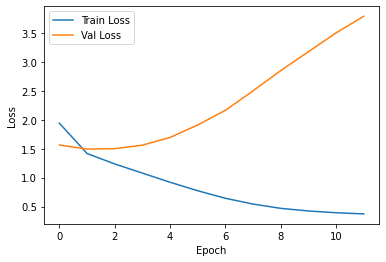

Best Epoch: 2
Validation Loss: 1.4944841861724854


In [ ]:
# Assuming max_length is the uniform length of your padded sequences
# and vocab_size is the size of your vocabulary
max_length = 126  # Example max length of sequences
vocab_size = 10000  # Example vocabulary size
embedding_dim = 50  # Dimensionality of the embedding layer

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(len(df['category'].unique()), activation='softmax'))  # Output layer

# Compile the model again with the corrected input length
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop])


# Predict
loss, accuracy = model.evaluate(X_test, y_test)
print("CNN Accuracy:", accuracy)


# Plot the train loss and the val loss for each epoch
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

best_epoch = np.argmin(history.history['val_loss'])
print("Best Epoch:", best_epoch+1)
print("Validation Loss:", history.history['val_loss'][best_epoch])



In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print("CNN Accuracy:", accuracy)

# Predict on test data
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert y_test_one_hot back to categorical labels
y_test = np.argmax(y_test, axis=1)

# Generate classification report
target_names = ['{}'.format(i) for i in range(len(df['category'].unique()))]
print("CNN Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

433/433 [==============================] - 1s 2ms/step - loss: 1.4749 - accuracy: 0.5964
CNN Accuracy: 0.5964277982711792
433/433 [==============================] - 1s 2ms/step
CNN Report:
              precision    recall  f1-score   support

           0       0.45      0.38      0.41       245
           1       0.46      0.34      0.39       287
           2       0.44      0.37      0.41       387
           3       0.33      0.12      0.17        69
           4       0.60      0.34      0.43       339
           5       0.58      0.33      0.42       250
           6       0.82      0.68      0.75       224
           7       0.52      0.18      0.27        72
           8       0.61      0.61      0.61      1133
           9       0.52      0.25      0.34       105
          10       0.00      0.00      0.00        95
          11       0.66      0.70      0.68       432
          12       0.33      0.02      0.04        85
          13       0.31      0.21      0.25       159


/home/xiong.ru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiong.ru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiong.ru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


433/433 [==============================] - 1s 2ms/step


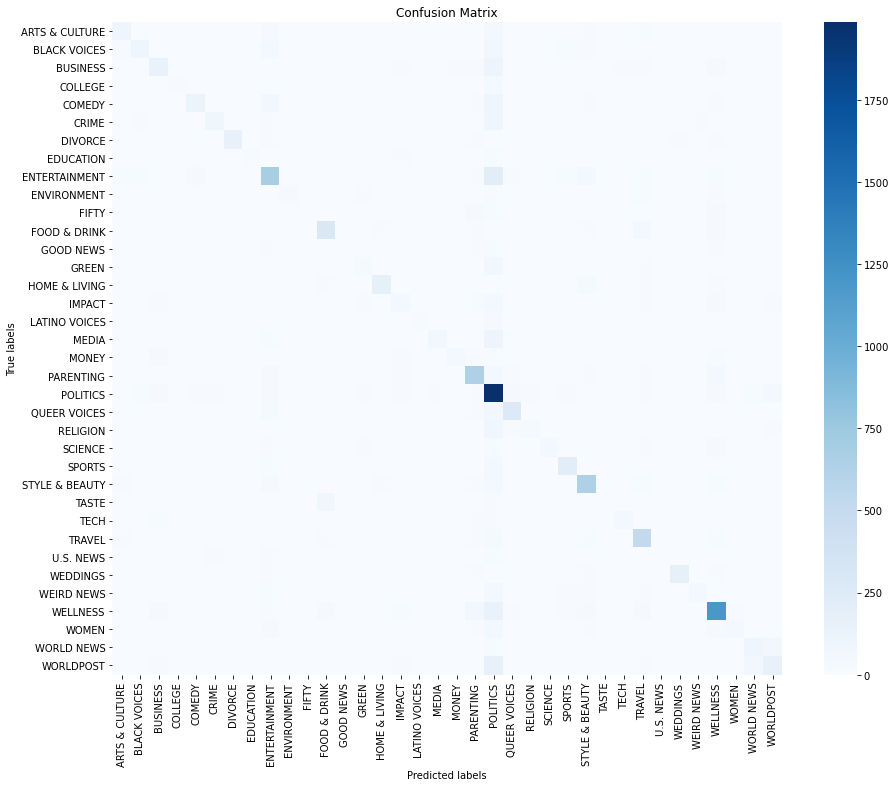

In [ ]:
# Generate predictions
predictions_prob = model.predict(X_test)
# Convert probabilities to class labels
predictions = predictions_prob.argmax(axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=np.unique(df['category']), yticklabels=np.unique(df['category']))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 3. Comparative Analysis

### Logistic Regression
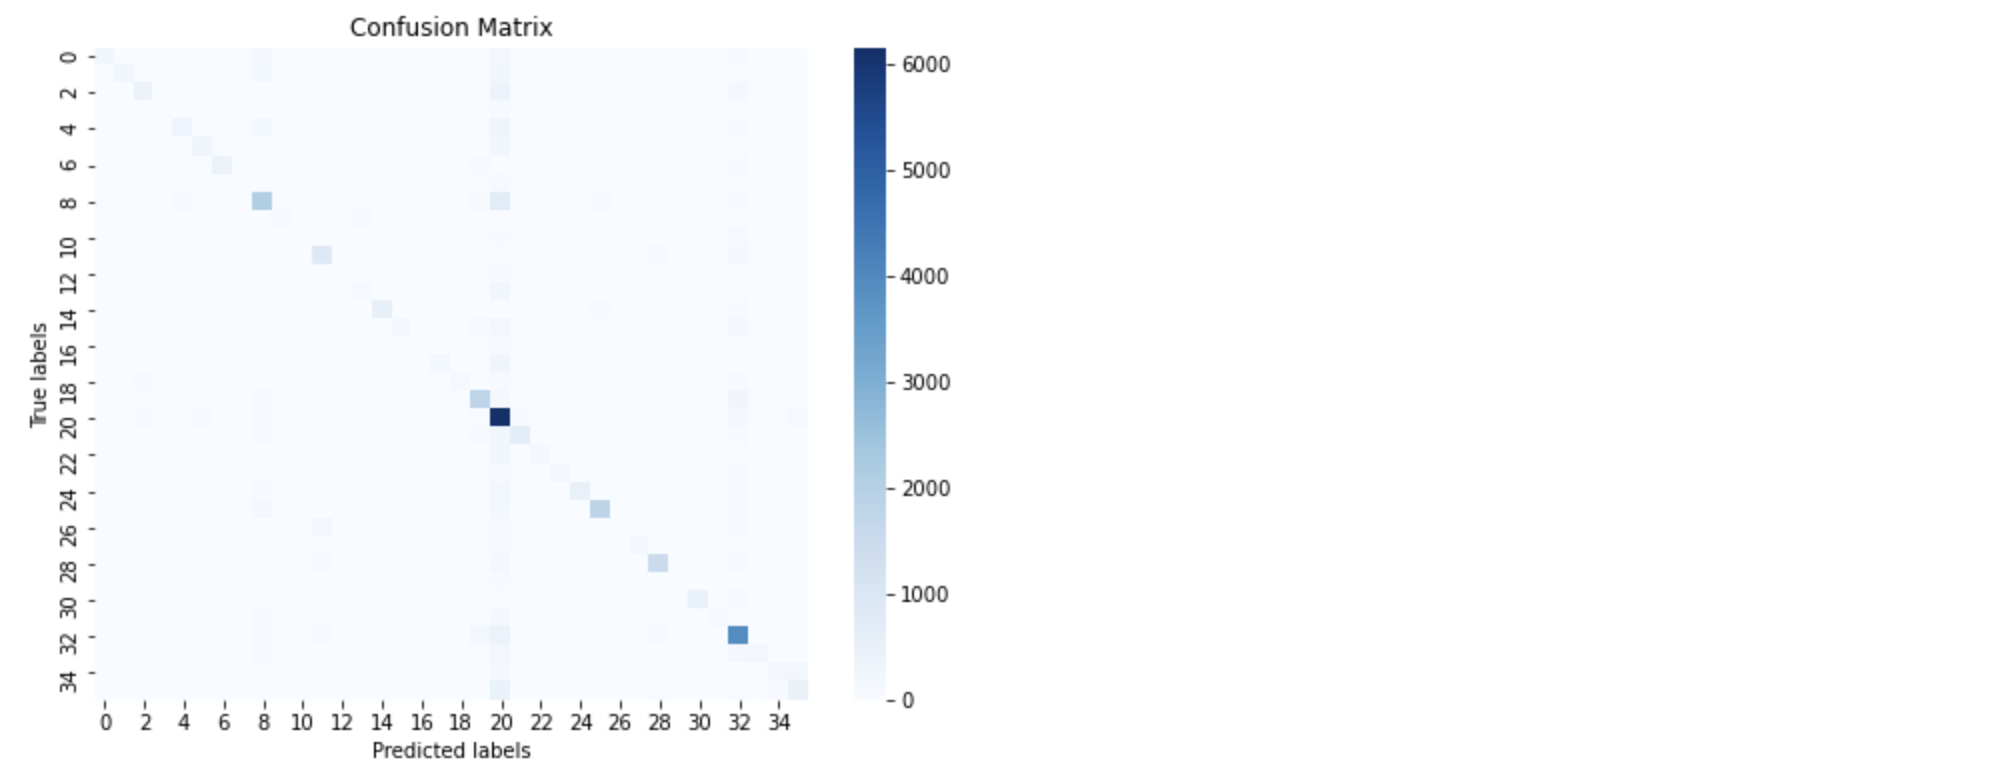
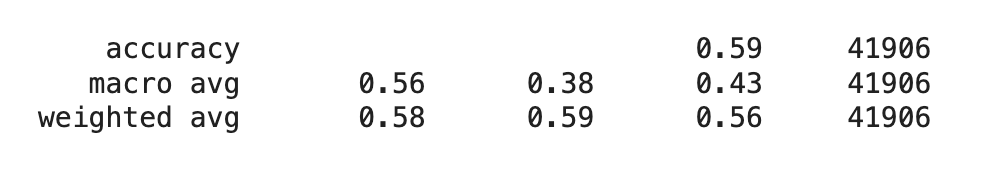

### Random Forest
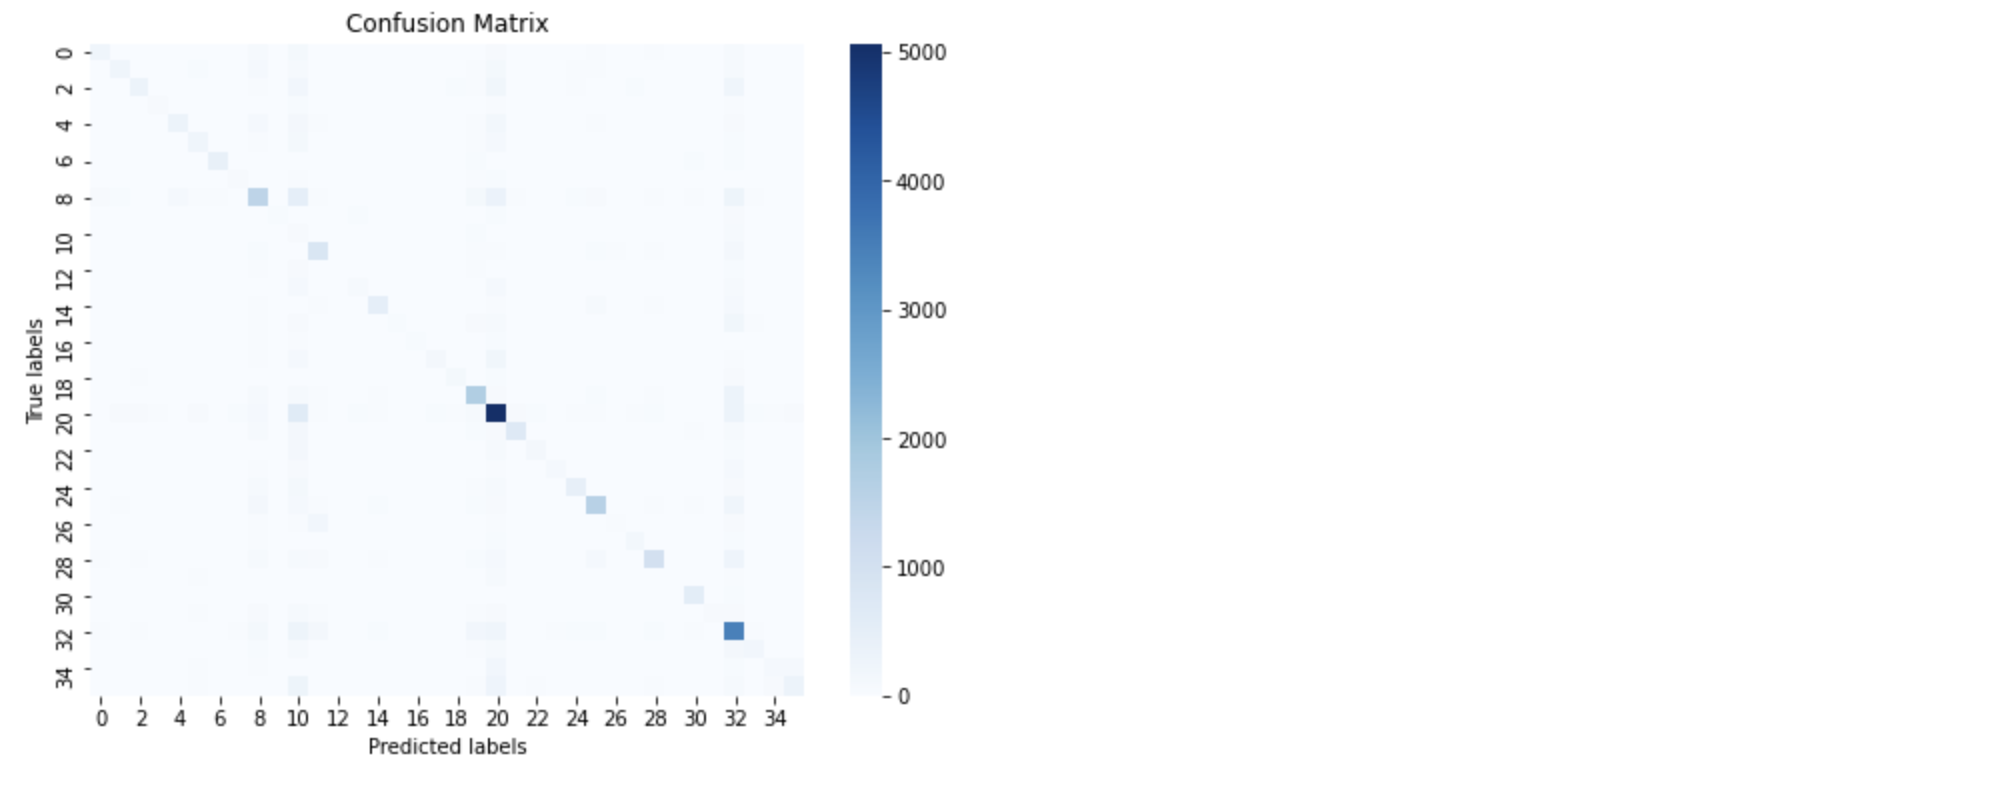
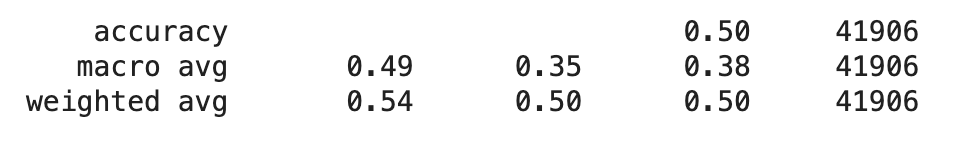

### XGBoost
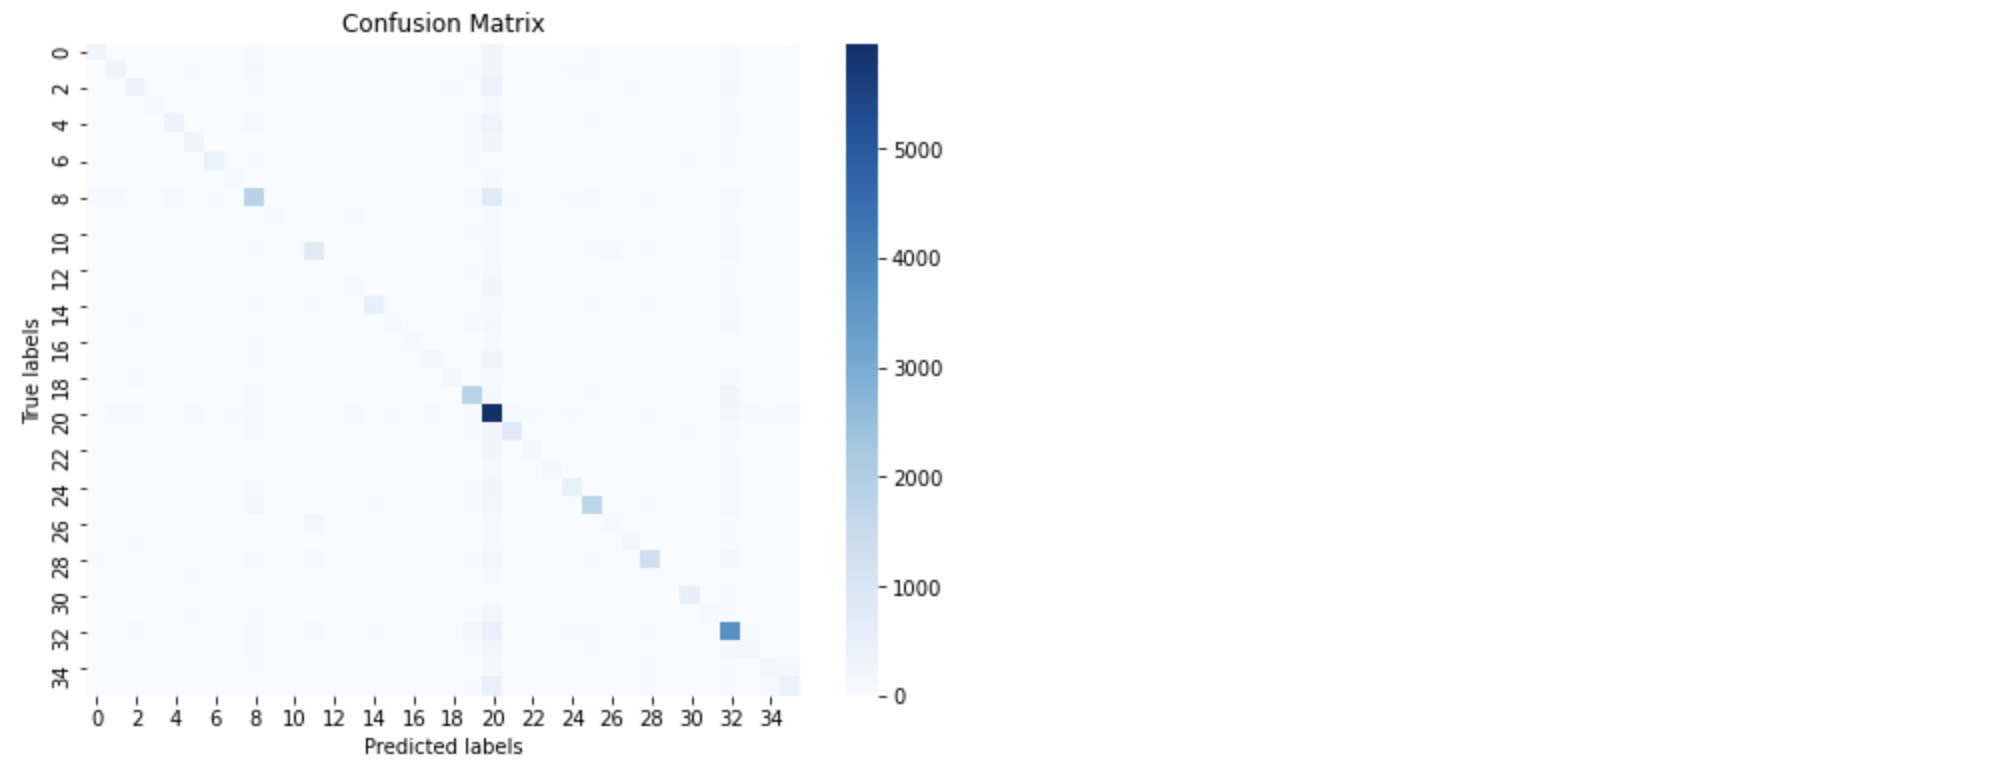
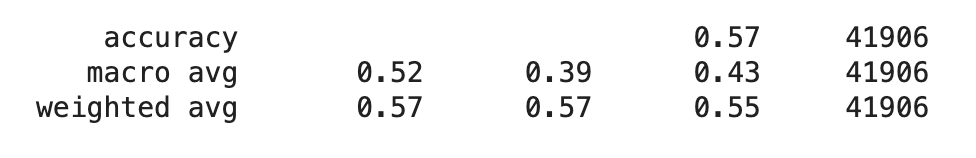


### ANN

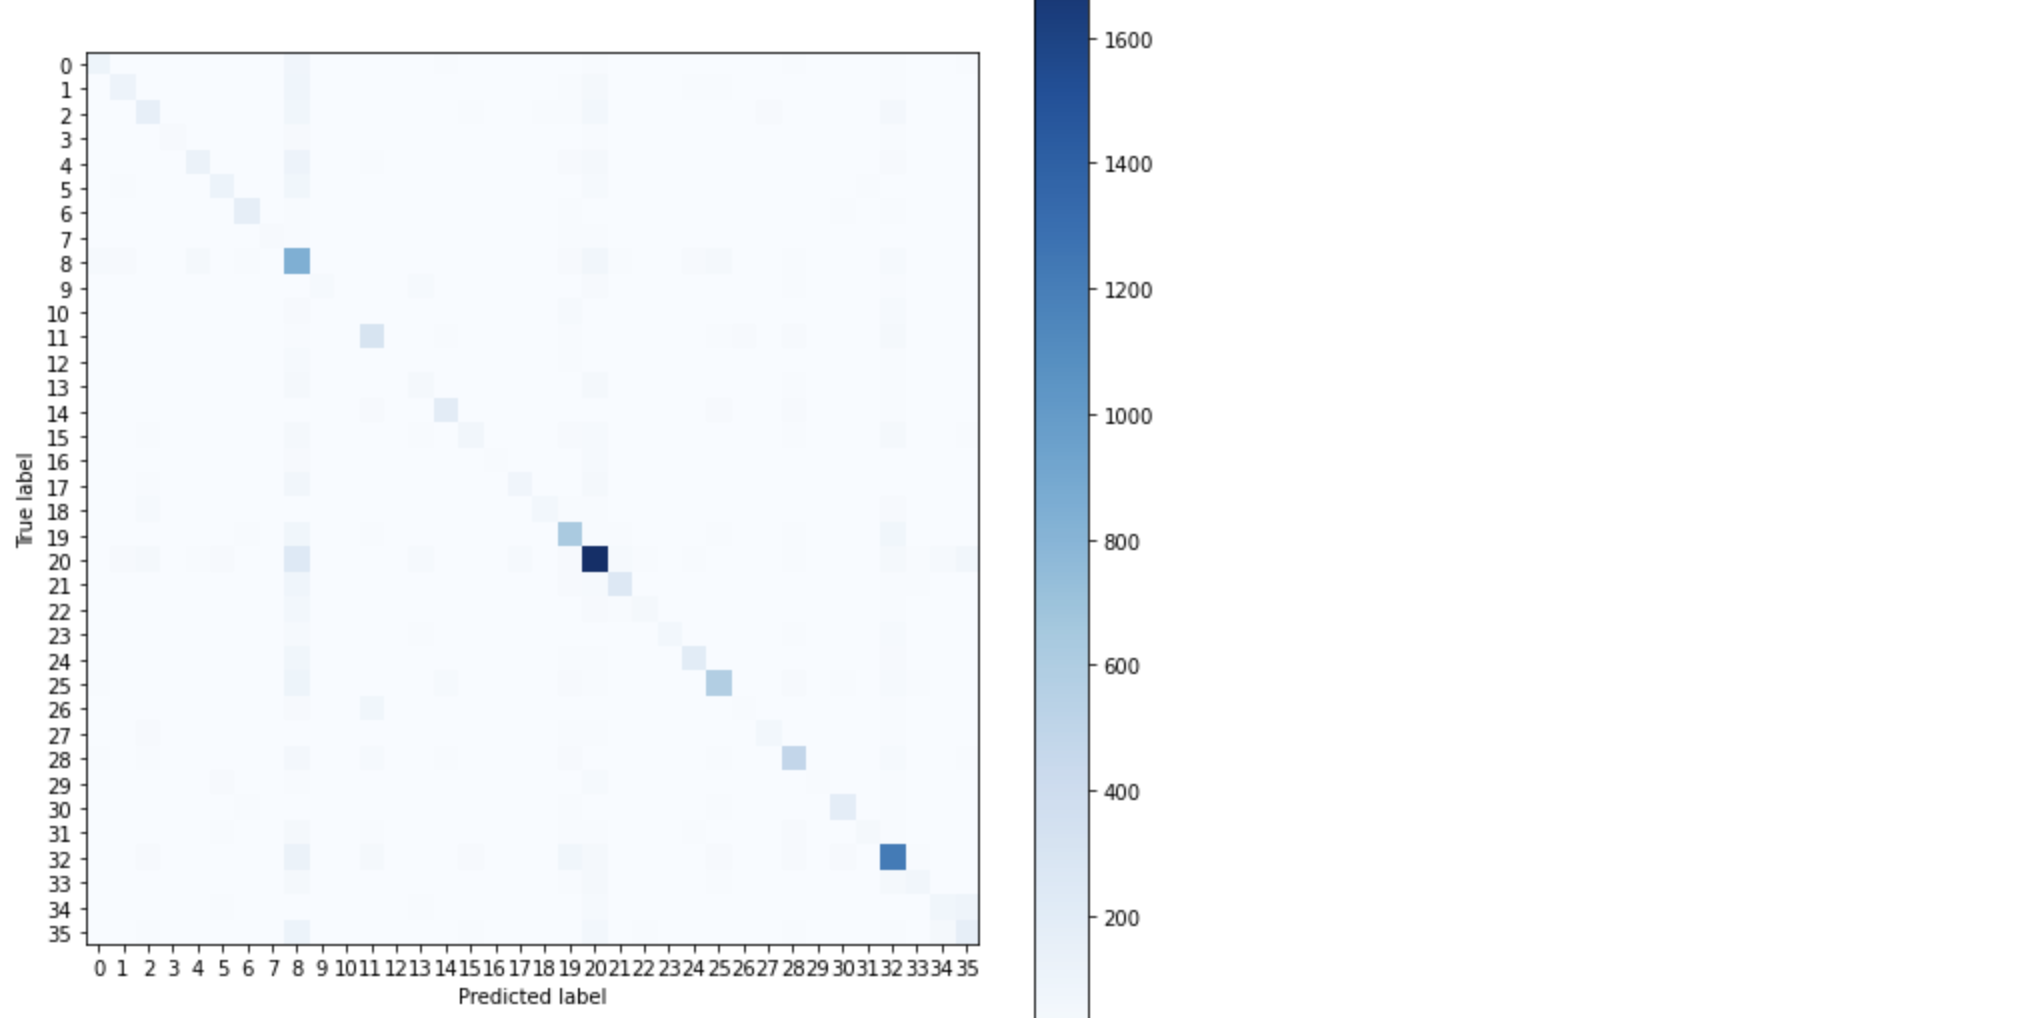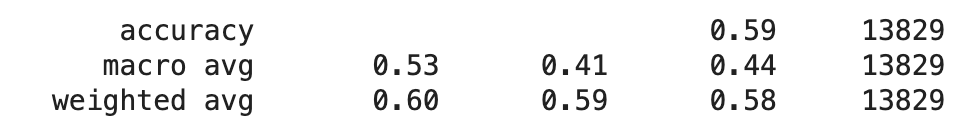

### CNN
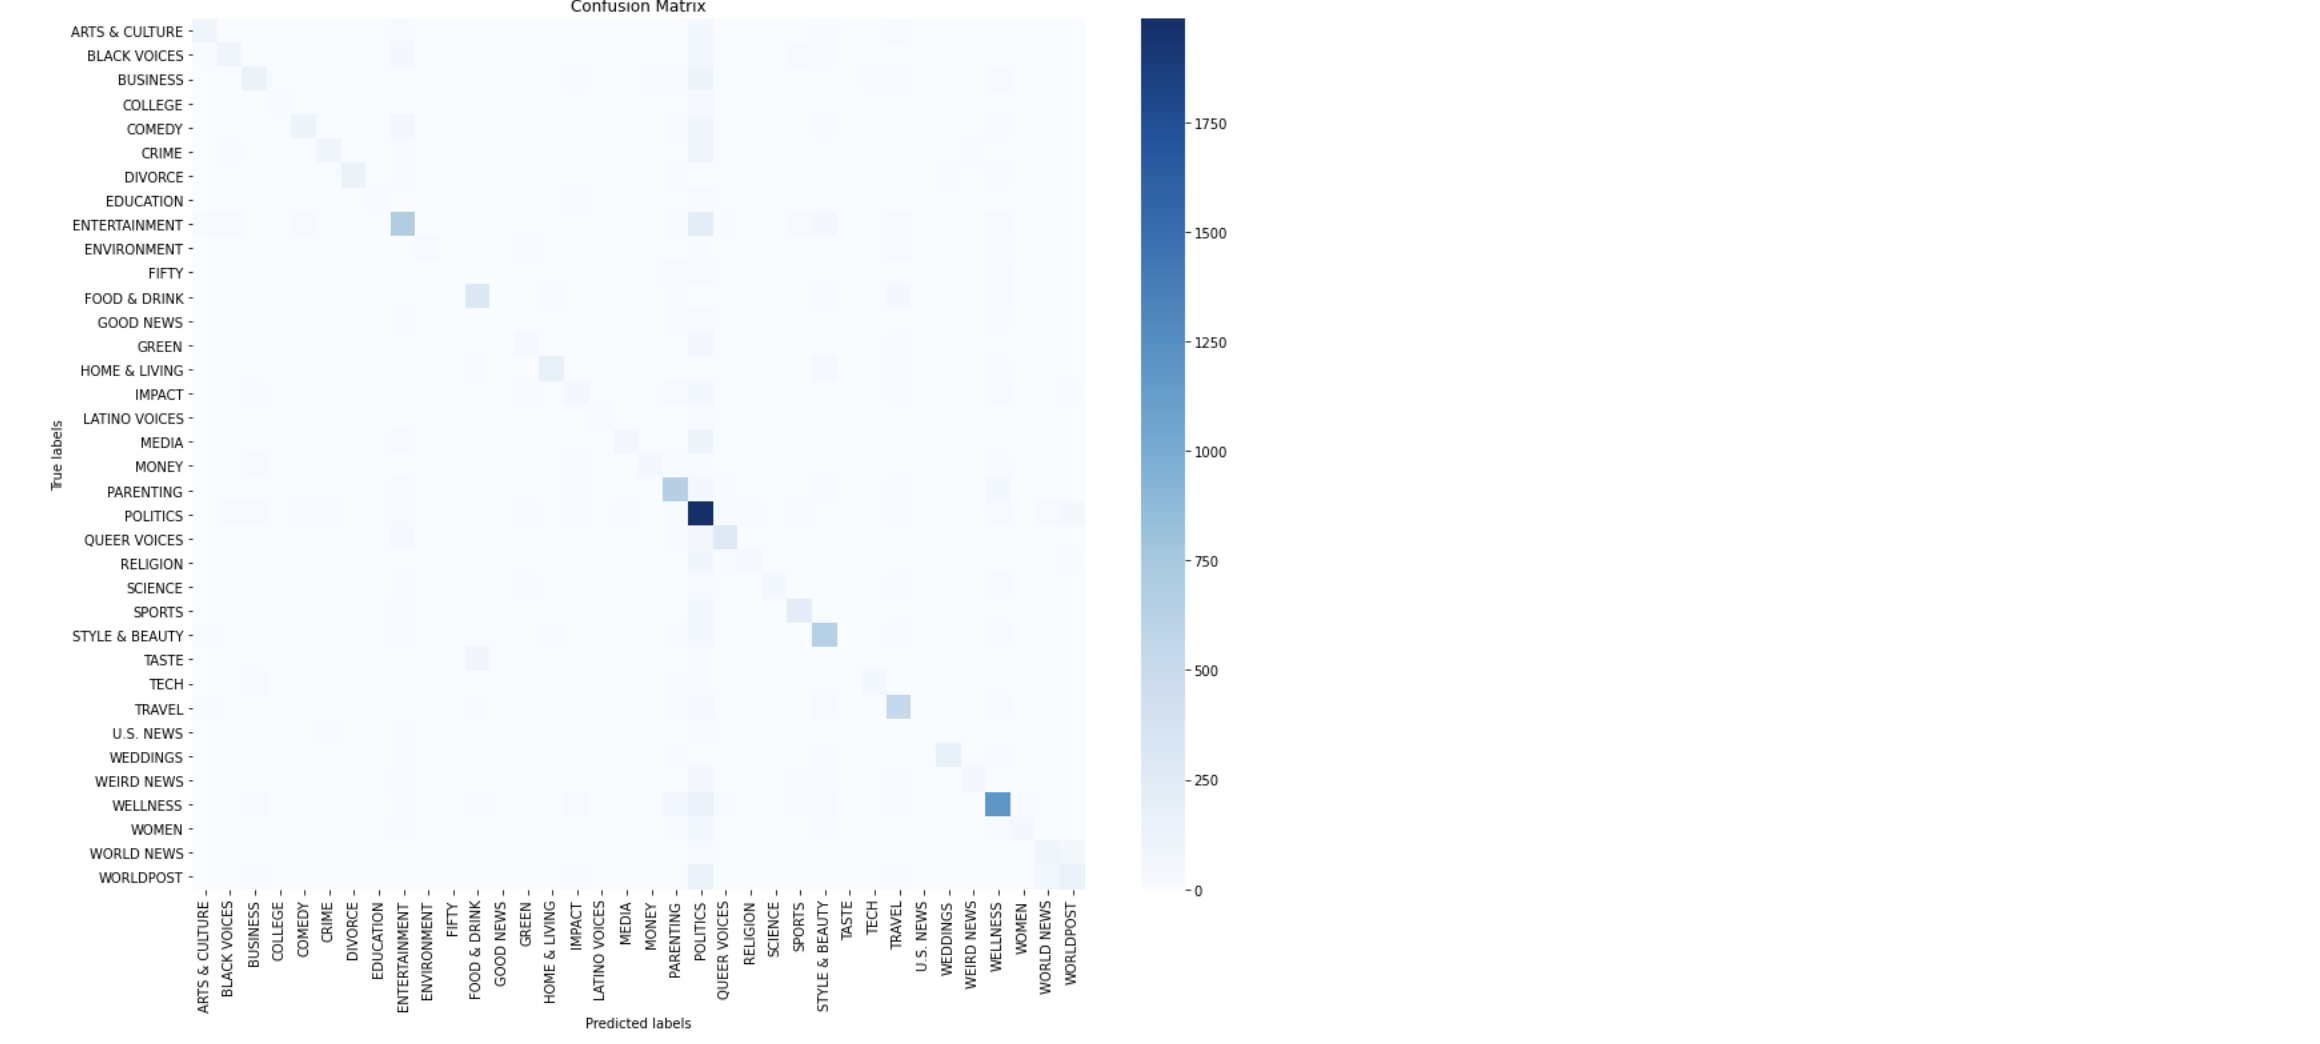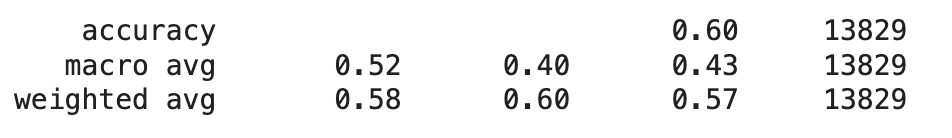

**Conventional ML techniques  VS.  deep learning techniques**


1.   As we can see above, there's not huge difference in the performance between conventional ML models and DL models. Although CNN slightly beat ML models;
2.   Tree base models take much more time to train since they're computationally more complex.
3.  The ANN and CNN models we built are mainly shallow neural networks and small CNN. Their computational cost is not high.
4.  However, NN modes are more likely to overfit, so we applied validation set and early stopping techniques to prevent overfitting



## 4. Discussion

**Challenges**


1.   Logistic Regression takes shorter time and get very good prediction performance. We tried using SVD for dimensionality deduction and the accuracy didn't improve for Logistic Regression so we stick to the orignial dataset;
2.   For tree based models, takes much longer to run, computationally heavy;
3.   Neural Networks can overfit easily, so we introduced validation set and early_stop techniques to avoid over fitting.




**Importance of feature engineering**


1.   For text classification tasks, the quality of preprocessing and feature engineering hugely affect the performance of the prediction.
2.   By using TF-IDF we embedded the tokens to numerical features(frequency), which makes it possible to continue building the models.

**More thoughts**


1.   We can tell that our accuracy for predicting is not very high so far; We probably can try other methods for classification instead of just using TF-IDF
2.   It's worth thinking to try using transformer models and other feature engineering method to build the whole pipeline to see if the accuracy can increase.


